# Section10 特徴量選択

## Greedy Feature Selection

- penguins_size.csvのデータセットを使用
- 前処理
    - 欠損値が多いデータは削除
    - カテゴリカルの欠損値にはNaNを代入し新たなカテゴリとして扱う
    - one-hot encodingでダミー変数化
    - 標準化
- 特徴量エンジニアリング
    - 多項式特徴量
    - 四則演算
- grdeey feature selectionをクラスで実装
    - k-Foldで評価
    - 引数にPipelineを受け取る
- 精度の推移と、選択された特徴量確認

In [1]:
import pandas as pd
import numpy as np

# データ抽出
df = pd.read_csv('penguins_size.csv')

# 前処理
df.loc[df[df['sex'] == '.'].index, 'sex'] = np.nan
df.dropna(thresh=3, inplace=True)  # thresh=3と引数を渡すことで、カラムが3つ以上NoneのIndexを削除する

In [2]:
# X,y生成
X = df.drop('species', axis=1)
y = df['species']

# 'sex'カラムの欠損値を新たなカテゴリ'NaN'として扱う
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value='NaN')
imputer.set_output(transform='pandas')
X['sex'] = imputer.fit_transform(X[['sex']])

# One-hot encoding生成自作クラス
from sklearn.base import BaseEstimator, TransformerMixin
class GetDummies(BaseEstimator, TransformerMixin):
    """
    BaseEstimatorとTransformMininクラスを継承した
    ダミー変数のカラムを作るクラス
    """
    
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns=self.columns, fill_value=0)
    
# 特徴量エンジニアリング
# 多項式特徴量
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_cols = ['culmen_length_mm', 'culmen_depth_mm', 'culmen_length_mm^2', 'culmen_depth_mm^2', 'culmen_length_mm * culmen_depth_mm']
X[poly_cols] = poly.fit_transform(X[['culmen_length_mm', 'culmen_depth_mm']])  
# 四則演算
X['clumen_diff'] = X['culmen_length_mm'] - X['culmen_depth_mm']
X['clumen_ratio'] = X['culmen_length_mm'] / X['culmen_depth_mm']

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([('dummy', GetDummies()), 
          ('scaler', StandardScaler()), 
          ('model', LogisticRegression())])

# cv
from sklearn.model_selection import KFold
cv = KFold(n_splits=3, random_state=0, shuffle=True)

In [1]:
# Feature Selection
from sklearn.model_selection import cross_val_score
class GreedyFeatureSelection():
    
    def __init__(self, pipeline, cv):
        self.pipeline = pipeline
        self.cv = cv
        self.selected_features = []
        self.scores = [0]
    
    def select_feature(self, X, y):
        
        all_features = X.columns
        
        while True:
            print('greedy selection started')
            best_score = self.scores[-1]
            candidate_feature = None
            for feature in all_features:
                if feature in self.selected_features:
                    # 同じfeatureが重複してリスト生成されないように、同じfeatureが来たらskipする
                    continue
                print(f'{feature} started')
                features = self.selected_features + [feature]
                X_train = X[features]
                # 評価
                score = cross_val_score(self.pipeline, X_train, y, cv=self.cv).mean()
                print(f'{features} score: {score}')
                if score > best_score:
                    print(f'best score updated {best_score} -> {score}')
                    best_score = score
                    candidate_feature = feature
            
            if candidate_feature is not None:
                print(f'========{candidate_feature} is selected=============')
                self.scores.append(best_score)
                self.selected_features.append(candidate_feature)
            else:
                break

In [4]:
# Greedy feature selection
gfs = GreedyFeatureSelection(pipeline=pipeline, cv=cv)
gfs.select_feature(X, y)

greedy selection started
island started
['island'] score: 0.7076023391812866
best score updated 0 -> 0.7076023391812866
culmen_length_mm started
['culmen_length_mm'] score: 0.7514619883040936
best score updated 0.7076023391812866 -> 0.7514619883040936
culmen_depth_mm started
['culmen_depth_mm'] score: 0.7573099415204679
best score updated 0.7514619883040936 -> 0.7573099415204679
flipper_length_mm started
['flipper_length_mm'] score: 0.7982456140350876
best score updated 0.7573099415204679 -> 0.7982456140350876
body_mass_g started
['body_mass_g'] score: 0.7309941520467835
sex started
['sex'] score: 0.39181286549707606
culmen_length_mm^2 started
['culmen_length_mm^2'] score: 0.7543859649122808
culmen_depth_mm^2 started
['culmen_depth_mm^2'] score: 0.5350877192982456
culmen_length_mm * culmen_depth_mm started
['culmen_length_mm * culmen_depth_mm'] score: 0.7573099415204679
clumen_diff started
['clumen_diff'] score: 0.8187134502923977
best score updated 0.7982456140350876 -> 0.818713450292

In [5]:
gfs.scores

[0, 0.9619883040935672, 0.9912280701754387, 0.9970760233918128, 1.0]

In [6]:
gfs.selected_features

['clumen_ratio', 'island', 'clumen_diff', 'body_mass_g']

## Recursive feature eliminate(RFE)

RFE
- sklearn.feature_selection.RFEクラス
    1. インスタンス生成
        - estimator: sklearnのモデルインスタンス
        - n_feaures_to_select: 最終的に選択する特徴量数
    2. .fit(X, y)でRFEを実施し特徴量選択する
    3. transform(X)で削減された特徴量するX’を返す
        - rankingで特徴量の重要度順を確認できる
        - .support_で特徴量の選択結果のマスクを取得
- sklearn.feature_selectionRFECVクラス
    - RFEをCVで実行できる

### RFEクラス

In [7]:
# RFEクラス
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# モデルは決定木、最終的に6の特徴量数でRFEを実施
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=6)
X = pd.get_dummies(X, drop_first=True)
rfe.fit(X, y)
rfe.transform(X)

array([[20.4       ,  2.09090909,  0.        ,  1.        ,  1.        ,
         0.        ],
       [22.1       ,  2.27011494,  0.        ,  1.        ,  0.        ,
         0.        ],
       [22.3       ,  2.23888889,  0.        ,  1.        ,  0.        ,
         0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ,  0.        ,  1.        ,
         0.        ],
       [30.4       ,  3.05405405,  0.        ,  0.        ,  0.        ,
         0.        ],
       [33.8       ,  3.09937888,  0.        ,  0.        ,  1.        ,
         0.        ]])

In [8]:
# 1のランキングのカラムが重要度高い
rfe.ranking_

array([8, 7, 6, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1])

In [9]:
# ランキングが1のカラムのみを抜き出す
rfe.feature_names_in_[rfe.ranking_==1]
# rfe.feature_names_in_[rfe.support_]  # 上記の書き方は.support_を使ってこのようにも書ける

array(['clumen_diff', 'clumen_ratio', 'island_Dream', 'island_Torgersen',
       'sex_MALE', 'sex_NaN'], dtype=object)

In [10]:
pipeline = Pipeline([('rfe', rfe), 
                     ('scaler', StandardScaler()), 
                     ('model', LogisticRegression())])
scores = cross_val_score(pipeline, X, y, cv=cv)
print(scores)

[1.         0.99122807 0.99122807]


### RFECVクラス

In [11]:
# RFECVクラス
from sklearn.feature_selection import RFECV

cv = KFold(n_splits=3, random_state=0, shuffle=True)
rfecv = RFECV(estimator=DecisionTreeClassifier(), cv=cv)
rfecv.fit(X, y)
rfecv.transform(X)

array([[20.4       ,  2.09090909,  0.        ],
       [22.1       ,  2.27011494,  0.        ],
       [22.3       ,  2.23888889,  0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ],
       [30.4       ,  3.05405405,  0.        ],
       [33.8       ,  3.09937888,  0.        ]])

In [12]:
rfecv.feature_names_in_[rfecv.support_]

array(['clumen_diff', 'clumen_ratio', 'island_Dream'], dtype=object)

Text(0, 0.5, 'mean test score')

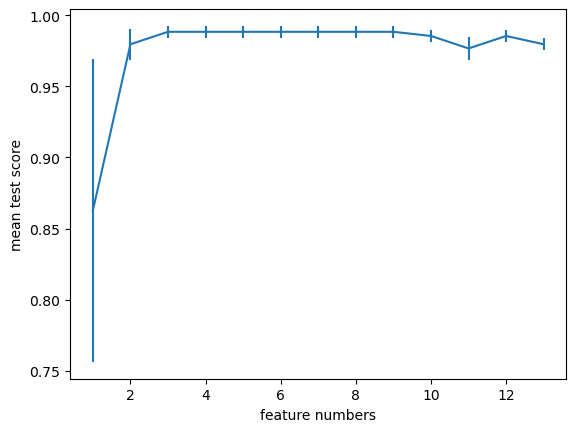

In [13]:
# 特徴量10個よりも、4~8個の方が精度が高くなっている
# このことから、4個の特徴量がrfeにより選択されたことになる
# 特徴量が多いということは、テストデータにも特徴量の情報を求めることになり、運用コストが高くなりがち
# そのため、機械学習PJTではなるべく特徴量を少なくしてやるのが望ましい

# rfecv.cv_results_
import matplotlib.pyplot as plt
plt.errorbar(range(1, 1+len(rfecv.cv_results_['mean_test_score'])),
             rfecv.cv_results_['mean_test_score'],
             yerr=rfecv.cv_results_['std_test_score'])
plt.xlabel('feature numbers')
plt.ylabel('mean test score')

In [14]:
rfecv.cv_results_['mean_test_score']

array([0.8625731 , 0.97953216, 0.98830409, 0.98830409, 0.98830409,
       0.98830409, 0.98830409, 0.98830409, 0.98830409, 0.98538012,
       0.97660819, 0.98538012, 0.97953216])

In [15]:
rfecv.cv_results_

{'mean_test_score': array([0.8625731 , 0.97953216, 0.98830409, 0.98830409, 0.98830409,
        0.98830409, 0.98830409, 0.98830409, 0.98830409, 0.98538012,
        0.97660819, 0.98538012, 0.97953216]),
 'std_test_score': array([0.1063138 , 0.01094052, 0.00413513, 0.00413513, 0.00413513,
        0.00413513, 0.00413513, 0.00413513, 0.00413513, 0.00413513,
        0.00827025, 0.00413513, 0.00413513]),
 'split0_test_score': array([0.97368421, 0.99122807, 0.99122807, 0.99122807, 0.99122807,
        0.99122807, 0.99122807, 0.99122807, 0.99122807, 0.99122807,
        0.98245614, 0.99122807, 0.98245614]),
 'split1_test_score': array([0.89473684, 0.98245614, 0.99122807, 0.99122807, 0.99122807,
        0.99122807, 0.99122807, 0.99122807, 0.99122807, 0.98245614,
        0.96491228, 0.98245614, 0.97368421]),
 'split2_test_score': array([0.71929825, 0.96491228, 0.98245614, 0.98245614, 0.98245614,
        0.98245614, 0.98245614, 0.98245614, 0.98245614, 0.98245614,
        0.98245614, 0.98245614, 0.98

## モデルの重要度から特徴量選択

SelectFromModel
- sklearn.feature_selection.SelectFromModelクラス
    1. インスタンス生成
        - estimator: sklearnのモデル
        - thershold: 重要度の閾値, 'mean', 'median', '1.25*mean'なども可能
    2. .fit(X,y)で学習
    3. .transform(X)で削減された特徴量X’を返す
    - estimator_でモデルインスタンスにアクセス可能
    - .get_support()で特徴量の選択結果のマスクを取得

### RandomForest

In [17]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

sfm = SelectFromModel(estimator=RandomForestClassifier(random_state=0))
X_selected = sfm.fit_transform(X, y)

In [19]:
X_selected

array([[ 39.1       ,  18.7       , 181.        , ..., 349.69      ,
         20.4       ,   2.09090909],
       [ 39.5       ,  17.4       , 186.        , ..., 302.76      ,
         22.1       ,   2.27011494],
       [ 40.3       ,  18.        , 195.        , ..., 324.        ,
         22.3       ,   2.23888889],
       ...,
       [ 50.4       ,  15.7       , 222.        , ..., 246.49      ,
         34.7       ,   3.21019108],
       [ 45.2       ,  14.8       , 212.        , ..., 219.04      ,
         30.4       ,   3.05405405],
       [ 49.9       ,  16.1       , 213.        , ..., 259.21      ,
         33.8       ,   3.09937888]])

In [21]:
sfm.estimator_

RandomForestClassifier(random_state=0)

In [22]:
sfm.estimator_.feature_names_in_

array(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'culmen_length_mm^2', 'culmen_depth_mm^2',
       'culmen_length_mm * culmen_depth_mm', 'clumen_diff',
       'clumen_ratio', 'island_Dream', 'island_Torgersen', 'sex_MALE',
       'sex_NaN'], dtype=object)

In [26]:
# 特徴量の重要度
sfm.estimator_.feature_importances_

array([0.08924232, 0.07961904, 0.09933245, 0.0525517 , 0.08072858,
       0.01467092, 0.10925035, 0.14543881, 0.24562145, 0.07424349,
       0.00630753, 0.00299336, 0.        ])

In [25]:
# 選択された特徴量
sfm.get_support()

array([ True,  True,  True, False,  True, False,  True,  True,  True,
       False, False, False, False])

## L1正則化項で特徴量選択

In [28]:
# estimtatorにl1正則を使用するモデルを入れると，l1正則を使って特徴量選択が可能
sfm = SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='liblinear'))
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('feature_selection', sfm)])
pipeline.set_output(transform='pandas')
pipeline.fit_transform(X, y)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,culmen_depth_mm^2,culmen_length_mm * culmen_depth_mm,clumen_diff,clumen_ratio,island_Dream,island_Torgersen,sex_MALE
0,-0.884499,0.785449,-1.418347,-0.564142,-0.170197,0.768371,-1.024588,-1.036429,-0.754193,2.388699,1.017700
1,-0.811126,0.126188,-1.062250,-0.501703,-0.550838,0.070068,-0.751183,-0.675598,-0.754193,2.388699,-0.982607
2,-0.664380,0.430462,-0.421277,-1.188532,-0.220261,0.386112,-0.719018,-0.738471,-0.754193,2.388699,-0.982607
4,-1.324737,1.089724,-0.563715,-0.938776,-0.368543,1.107627,-1.507068,-1.417695,-0.754193,2.388699,-0.982607
5,-0.847812,1.748985,-0.777373,-0.689020,0.510134,1.879435,-1.297994,-1.405186,-0.754193,2.388699,1.017700
...,...,...,...,...,...,...,...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.903175,-0.903628,-1.642135,1.082241,1.690550,-0.754193,-0.418638,-0.982607
340,0.527932,-1.445897,1.003109,0.809516,-0.707537,-1.392157,0.921415,1.343164,-0.754193,-0.418638,-0.982607
341,1.188289,-0.735923,1.501644,1.933419,0.351353,-0.767211,1.275233,1.217248,-0.754193,-0.418638,1.017700
342,0.234440,-1.192335,0.789451,1.246590,-0.709967,-1.175658,0.583679,0.902865,-0.754193,-0.418638,-0.982607


In [30]:
sfm.estimator_.coef_

array([[ 0.        ,  0.        , -0.17319229,  0.        ,  0.        ,
         0.        ,  0.08427615, -6.97866855,  0.        , -0.34809953,
         0.89175751,  1.17687179,  0.        ],
       [ 4.21393324,  0.        ,  0.        , -2.37085945,  0.        ,
         0.1471555 ,  0.        ,  0.        ,  0.        ,  2.66132682,
         0.        , -0.75563799,  0.        ],
       [ 0.        , -2.75911655,  1.71211685,  1.80030741,  0.        ,
         0.        ,  0.        ,  0.        ,  0.52518221, -0.25191405,
         0.        ,  0.        ,  0.        ]])

In [33]:
sfm.get_support()

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False])